# 🩺 NLP Médical – Pipeline complet avec transcription + classification + NER + résumé
Ce notebook réalise :
- La transcription d'un audio médical
- Le fine-tuning de CamemBERT sur un jeu de données de classification médicale
- La classification du thème
- L'extraction d'entités médicales (NER)
- Le résumé automatique du texte

**⚠️ Remarque** : ce notebook est prévu pour être exécuté sur Google Colab (GPU recommandé pour l'entraînement).

In [1]:
# 📦 Étape 0 – Installation des dépendances
!pip install -q transformers datasets torchaudio librosa sentencepiece gradio #scikit-learn

In [2]:
#!pip install --upgrade transformers
#!pip install scikit-learn
#!pip install numpy pandas --upgrade --force-reinstall
#!pip uninstall pandas numpy -y
#!pip install pandas

In [3]:
# 📁 Étape 1 – Charger le dataset de classification médicale
import pandas as pd
df = pd.read_csv("medical_dataset.csv")
df.head()

,text,label,label_id
0,Le patient souffre d'hypertension et doit surv...,cardio,0
1,On note une tachycardie persistante suite à un...,cardio,0
2,Le patient est très stressé souffre de trouble...,psy,1
3,La dépression est diagnostiquée depuis plusieu...,psy,1
4,La glycémie est instable malgré le traitement ...,diabete,2


In [4]:
import pandas as pd

# Ton jeu de données original
df_orig = pd.read_csv("medical_dataset.csv")

# Données enrichies simulées
data_new = [
    ("Le patient présente une arythmie et des douleurs thoraciques.", "cardio", 0),
    ("Un souffle cardiaque est détecté à l’auscultation.", "cardio", 0),
    ("On observe une bradycardie persistante chez le patient.", "cardio", 0),
    ("Le patient est sujet à des attaques de panique fréquentes.", "psy", 1),
    ("Il rapporte des troubles de concentration et une humeur dépressive.", "psy", 1),
    ("Des signes de schizophrénie ont été détectés au cours de l’entretien.", "psy", 1),
    ("La patiente suit un traitement à l’insuline pour contrôler son diabète.", "diabete", 2),
    ("Une hypoglycémie sévère a été observée après l’effort physique.", "diabete", 2),
    ("Le taux de sucre dans le sang reste élevé malgré le régime adapté.", "diabete", 2),
    ("Le patient souffre d’une crise cardiaque survenue à son domicile.", "cardio", 0),
    ("Il a consulté pour des idées suicidaires persistantes.", "psy", 1),
    ("Un nouveau traitement oral est prescrit pour le diabète de type 1.", "diabete", 2)
]

df_new = pd.DataFrame(data_new, columns=["text", "label", "label_id"])

# Fusionner
df_total = pd.concat([df_orig, df_new], ignore_index=True)
df_total.to_csv("medical_dataset_enriched.csv", index=False)

df_total.to_csv("base_medicale_etendue_.csv", index=False)



In [5]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# === 1. Chargement de ton dataset existant ===
df_total = pd.read_csv("base_medicale_etendue_.csv")  # ou ton fichier actuel

# Mapping labels string vers int
label2id = {"cardio": 0, "psy": 1, "diabete": 2}
df_total['label'] = df_total['label'].map(label2id)

# === 2. Chargement modèle GPT-2 pour génération ===
model_name = "dbddv01/gpt2-french-small"  # Modèle GPT-2 français standard (plus dispo que medical)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# === 3. Fonction de génération ===
def generate_sentences(prompt, n=20, max_length=50):
    sentences = []
    for _ in range(n):
        inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
        outputs = model.generate(
            inputs,
            max_length=max_length,
            do_sample=True,
            temperature=0.9,
            top_p=0.9,
            top_k=50,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
        text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # extraire uniquement la génération après le prompt
        generated = text[len(prompt):].strip()
        sentences.append(prompt + generated)
    return sentences

# === 4. Génération pour chaque classe ===
prompts_labels = {
    "cardio": "Le patient présente des symptômes cardiaques tels que",
    "psy": "Le patient souffre de troubles psychologiques comme",
    "diabete": "Le patient est atteint de diabète et présente",
}

generated_data = {"text": [], "label": []}

for label_str, prompt in prompts_labels.items():
    label_id = label2id[label_str]
    gen_sentences = generate_sentences(prompt, n=20)  # 20 phrases par classe
    generated_data["text"].extend(gen_sentences)
    generated_data["label"].extend([label_id]*len(gen_sentences))

# === 5. Créer DataFrame des données générées ===
df_generated = pd.DataFrame(generated_data)

# === 6. Concaténer au dataset initial ===
df_augmented = pd.concat([df_total, df_generated], ignore_index=True)

# === 7. Sauvegarder le dataset augmenté ===
df_augmented.to_csv("base_medicale_augmented.csv", index=False)

print(f"Dataset augmenté : {len(df_augmented)} exemples, dont {len(df_generated)} générés.")


Dataset augmenté : 78 exemples, dont 60 générés.


In [6]:
import pandas as pd
from datasets import Dataset

# Charger le fichier CSV
df = pd.read_csv("base_medicale_augmented.csv")  # remplace par le bon nom

# Supprimer la colonne label_id si elle existe
if 'label_id' in df.columns:
    df = df.drop(columns=['label_id'])

# Nettoyer les lignes vides ou incorrectes
df = df.dropna(subset=["text", "label"])
df = df[df["label"].apply(lambda x: str(x).isdigit())]
df["label"] = df["label"].astype(int)

# Vérifier la répartition des classes
print(df["label"].value_counts())
print(df.head())

# Sauvegarde propre (optionnelle)
df.to_csv("base_medicale_propre.csv", index=False)

# Conversion vers Hugging Face Dataset
dataset = Dataset.from_pandas(df)


label
0    26
1    26
2    26
Name: count, dtype: int64
                                                text  label
0  Le patient souffre d'hypertension et doit surv...      0
1  On note une tachycardie persistante suite à un...      0
2  Le patient est très stressé souffre de trouble...      1
3  La dépression est diagnostiquée depuis plusieu...      1
4  La glycémie est instable malgré le traitement ...      2


In [7]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# from DATA.MORE_DATA.data_generator import DataGenerator
# data_generator = DataGenerator()
# df = data_generator.get_df_medical()

# 📌 Étape 1 – Chargement et nettoyage
df1 = pd.read_csv("base_medicale_propre.csv")

# Si 'label' est déjà des entiers (0,1,2), on garde uniquement ceux valides
df1 = df1[df1['label'].isin([0, 1, 2])]

#df = pd.read_csv("Dataset_320_sentences.csv")
df2 = pd.read_csv("Dataset_less_sentences.csv")
df = pd.concat([df1, df2], ignore_index=True)

# S’assurer que c’est bien un entier
df['label'] = df['label'].astype(int)


# Supprimer les lignes restantes avec NaN
df = df.dropna(subset=["label", "text"])

# Convertir en entier
df['label'] = df['label'].astype(int)


# 💾 Pour debug : vérifier la distribution
print("Label distribution:\n", df['label'].value_counts())

# 📁 Étape 2 – Conversion en Dataset HF
dataset = Dataset.from_pandas(df)

# Split train/test
dataset = dataset.train_test_split(test_size=0.3, seed=42)

# Tokenizer CamemBERT
tokenizer = AutoTokenizer.from_pretrained("camembert-base")

# Préprocessing avec ajout des labels
def preprocess(example):
    tokenized = tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)
    tokenized["labels"] = example["label"]
    return tokenized

# Tokenization
encoded_dataset = dataset.map(preprocess, batched=True)

# Charger modèle CamemBERT pour classification (3 classes)
model = AutoModelForSequenceClassification.from_pretrained("camembert-base", num_labels=3)

# 🎯 Entraînement
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    learning_rate=5e-5,
    report_to="none"
)

# Métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted", zero_division=0)
    acc = accuracy_score(labels, predictions)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


# 🧠 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)

# 🚀 Lancer l'entraînement
trainer.train()

# 💾 Sauvegarder modèle et tokenizer
trainer.save_model("./results")
tokenizer.save_pretrained("./results")


Label distribution:
 label
2    111
0    110
1     91
Name: count, dtype: int64


Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.9607467651367188, 'eval_accuracy': 0.7021276595744681, 'eval_f1': 0.699099599136602, 'eval_precision': 0.763437849944009, 'eval_recall': 0.7021276595744681, 'eval_runtime': 1.926, 'eval_samples_per_second': 48.806, 'eval_steps_per_second': 6.231, 'epoch': 1.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.7264443039894104, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.7284197965684152, 'eval_precision': 0.7637804978230509, 'eval_recall': 0.723404255319149, 'eval_runtime': 1.9197, 'eval_samples_per_second': 48.967, 'eval_steps_per_second': 6.251, 'epoch': 2.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.7173978090286255, 'eval_accuracy': 0.7127659574468085, 'eval_f1': 0.7192888825636282, 'eval_precision': 0.7612781954887219, 'eval_recall': 0.7127659574468085, 'eval_runtime': 1.9216, 'eval_samples_per_second': 48.917, 'eval_steps_per_second': 6.245, 'epoch': 3.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.5224781632423401, 'eval_accuracy': 0.8297872340425532, 'eval_f1': 0.8305162764570446, 'eval_precision': 0.8346873323797603, 'eval_recall': 0.8297872340425532, 'eval_runtime': 1.9171, 'eval_samples_per_second': 49.033, 'eval_steps_per_second': 6.26, 'epoch': 4.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.6549152731895447, 'eval_accuracy': 0.7978723404255319, 'eval_f1': 0.8027912608512472, 'eval_precision': 0.8381983020647731, 'eval_recall': 0.7978723404255319, 'eval_runtime': 1.9193, 'eval_samples_per_second': 48.975, 'eval_steps_per_second': 6.252, 'epoch': 5.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.5684663653373718, 'eval_accuracy': 0.8297872340425532, 'eval_f1': 0.8344879991615135, 'eval_precision': 0.8529342997428103, 'eval_recall': 0.8297872340425532, 'eval_runtime': 1.9271, 'eval_samples_per_second': 48.777, 'eval_steps_per_second': 6.227, 'epoch': 6.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.5911812782287598, 'eval_accuracy': 0.8404255319148937, 'eval_f1': 0.8427035987967415, 'eval_precision': 0.8520030668966838, 'eval_recall': 0.8404255319148937, 'eval_runtime': 1.9216, 'eval_samples_per_second': 48.919, 'eval_steps_per_second': 6.245, 'epoch': 7.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.6389786601066589, 'eval_accuracy': 0.8297872340425532, 'eval_f1': 0.8330688057652711, 'eval_precision': 0.8410513141426784, 'eval_recall': 0.8297872340425532, 'eval_runtime': 1.926, 'eval_samples_per_second': 48.807, 'eval_steps_per_second': 6.231, 'epoch': 8.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.6858062744140625, 'eval_accuracy': 0.8404255319148937, 'eval_f1': 0.8422872340425531, 'eval_precision': 0.8473348916401343, 'eval_recall': 0.8404255319148937, 'eval_runtime': 1.921, 'eval_samples_per_second': 48.932, 'eval_steps_per_second': 6.247, 'epoch': 9.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.6704772710800171, 'eval_accuracy': 0.8297872340425532, 'eval_f1': 0.8330688057652711, 'eval_precision': 0.8410513141426784, 'eval_recall': 0.8297872340425532, 'eval_runtime': 1.9164, 'eval_samples_per_second': 49.05, 'eval_steps_per_second': 6.262, 'epoch': 10.0}
{'train_runtime': 145.5943, 'train_samples_per_second': 14.973, 'train_steps_per_second': 1.923, 'train_loss': 0.3226214000156948, 'epoch': 10.0}


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/sentencepiece.bpe.model',
 './results/added_tokens.json',
 './results/tokenizer.json')

In [8]:
texts =[]

texts.append("Le patient est très diabétique..")
texts.append("Le patient doit surveiller son taux de sucre")
texts.append("J'ai des bourdonnements d'oreilles fréquents")
texts.append("Le patient a une tension élevée")
texts.append("Le diabète de type 2 est difficile à contrôler dans ce cas.")
texts.append("On note une tachycardie persistante suite à une activité physique intense.")
texts.append("La dépression est diagnostiquée depuis plusieurs semaines.")
texts.append("Le diabète de type 2 est difficile à contrôler dans ce cas.")

labels = ['hypertension artérielle', 'diabete', 'troubles psychiques']

import torch
from torch.nn.functional import softmax
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # modèle sur le bon device

for text in texts :
    # Tokenisation
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Prédiction
    outputs = model(**inputs)
    prediction = outputs.logits.argmax(dim=-1).item()

    probs_list = softmax(outputs.logits).squeeze().tolist()
    print(f"Texte source : {text} ")
    print(f"Predictions :  {probs_list[0]:.2f}   {probs_list[1]:.2f}   {probs_list[2]:.2f}   => {prediction}") 
    print()

Texte source : Le patient est très diabétique.. 
Predictions :  0.01   0.01   0.98   => 2

Texte source : Le patient doit surveiller son taux de sucre 
Predictions :  0.01   0.01   0.98   => 2

Texte source : J'ai des bourdonnements d'oreilles fréquents 
Predictions :  0.98   0.01   0.01   => 0

Texte source : Le patient a une tension élevée 
Predictions :  0.05   0.01   0.94   => 2

Texte source : Le diabète de type 2 est difficile à contrôler dans ce cas. 
Predictions :  0.01   0.01   0.98   => 2

Texte source : On note une tachycardie persistante suite à une activité physique intense. 
Predictions :  0.98   0.01   0.01   => 0

Texte source : La dépression est diagnostiquée depuis plusieurs semaines. 
Predictions :  0.01   0.94   0.05   => 1

Texte source : Le diabète de type 2 est difficile à contrôler dans ce cas. 
Predictions :  0.01   0.01   0.98   => 2



/tmp/ipykernel_12185/1852980643.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs_list = softmax(outputs.logits).squeeze().tolist()


  0%|          | 0/12 [00:00<?, ?it/s]

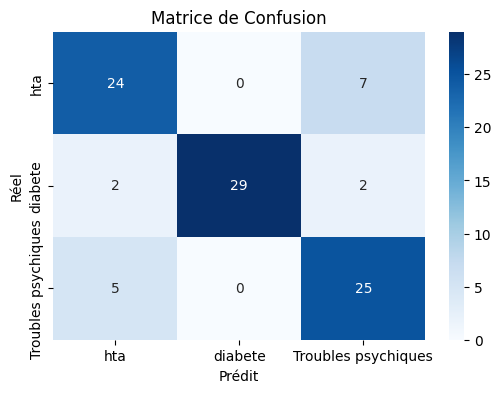

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
# Prédictions
preds_output = trainer.predict(encoded_dataset['test'])
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
labels = ['hta', 'diabete', 'Troubles psychiques']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

In [10]:
import torch
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Charger modèle et processeur Whisper
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

# Choisir device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Charger audio
audio_path = "diabete_3.mp3"
waveform, sr = torchaudio.load(audio_path)

# Resample à 16kHz
resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
waveform = resampler(waveform)

# Si audio stéréo (2 canaux), moyenne pour mono
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0)

# Convertir en numpy pour WhisperProcessor
waveform_np = waveform.numpy()

# Préparer les input features
inputs = processor(
    waveform_np,
    sampling_rate=16000,
    return_tensors="pt",
    return_attention_mask=False
)

# Padding manuel à 3000 frames (Whisper attend cette taille exacte)
input_features = inputs["input_features"]
if input_features.shape[-1] < 3000:
    pad_len = 3000 - input_features.shape[-1]
    input_features = torch.nn.functional.pad(input_features, (0, pad_len), mode="constant", value=0)

inputs["input_features"] = input_features.to(device)

# Générer la transcription
with torch.no_grad():
    forced_decoder_ids = processor.get_decoder_prompt_ids(language="fr", task="transcribe")
    generated_ids = model.generate(
        inputs["input_features"],
        forced_decoder_ids=forced_decoder_ids
    )

# Décoder la sortie en texte
transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("📄 Transcription :", transcription)
print("🖥️ Device utilisé :", device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


📄 Transcription :  Bonjour, Monsieur Dupont est atteint de diabète type 2 depuis 10 ans. Il présente une glisse et m'a l'équilibré malgré un traitement par metformine. Il se plaint de fatigue persistante et de piquotement dans les pieds. Son alimentation déséquilibrée, il a du mal à suivre les recommandations diététiques. Là, c'est le jour où il faut tout le monde se mobilise. C'est un cas critique. Il faut être pressé. Merci.
🖥️ Device utilisé : cuda


In [11]:
# 🩺 Étape 4 – Classification du thème médical avec le modèle entraîné
from transformers import pipeline, AutoModelForSequenceClassification

model_cls = AutoModelForSequenceClassification.from_pretrained("./results")
classifier = pipeline("text-classification", model=model_cls, tokenizer=tokenizer, return_all_scores=True)

# Appliquer la classification sur la transcription
all_scores = classifier(transcription)

# Affichage des scores pour chaque classe
print("🩺 Scores des thèmes médicaux détectés :")
for score in all_scores[0]:
    print(f"{score['label']}: {round(score['score']*100, 2)} %")


🩺 Scores des thèmes médicaux détectés :
LABEL_0: 0.93 %
LABEL_1: 1.26 %
LABEL_2: 97.81 %


/home/nicolascassonnet/Documents/WORK/aura-clinical-nlp/AURA-fastapi/.venv/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [12]:
#!pip install huggingface_hub --upgrade

In [13]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("Thibeb/DrBert_generalized")
model = AutoModelForTokenClassification.from_pretrained("Thibeb/DrBert_generalized")

ner_pipelineTh = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# 📄 Charger ta base (fichier CSV ou dataframe si déjà en mémoire)
df = pd.read_csv("medical_dataset_enriched.csv")  # ou ton fichier local

# 🔍 Appliquer le NER à chaque ligne du texte
def extract_entities(text):
    entities = ner_pipelineTh(text)
    return [(ent['word'], ent['entity_group']) for ent in entities]

df["entities"] = df["text"].apply(extract_entities)

# 🔎 Afficher quelques résultats
print(df[["text", "entities"]].head(10))

# 💾 Optionnel : sauvegarde dans un nouveau fichier CSV
df.to_csv("medical_dataset_with_entities_.csv", index=False)


                                                text  \
0  Le patient souffre d'hypertension et doit surv...   
1  On note une tachycardie persistante suite à un...   
2  Le patient est très stressé souffre de trouble...   
3  La dépression est diagnostiquée depuis plusieu...   
4  La glycémie est instable malgré le traitement ...   
5  Le diabète de type 2 est difficile à contrôler...   
6  Le patient présente une arythmie et des douleu...   
7  Un souffle cardiaque est détecté à l’auscultat...   
8  On observe une bradycardie persistante chez le...   
9  Le patient est sujet à des attaques de panique...   

                                            entities  
0            [(patient, LIVB), (hypertension, DISO)]  
1                  [(tach, DISO), (##ycardie, DISO)]  
2                      [(troubles du sommeil, DISO)]  
3                               [(depression, DISO)]  
4                   [(glyc, PROC), (insuline, CHEM)]  
5            [(diab, DISO), (##ete de type 2, DISO)] 

In [14]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

transcription2 = "Bonjour, le patient Mr Dupond présente une douleur et un diabète de type 2 non contrôlé avec une glycémie élevée et prend de la metformine."

models = {
    "DrBert_generalized": "Thibeb/DrBert_generalized",
    "Camembert_NER": "Jean-Baptiste/camembert-ner",
    "Thibeb/DrBert": "Thibeb/DrBert_generalized"
}

for name, model_path in models.items():
    print(f"\n--- Résultats avec {name} ---")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForTokenClassification.from_pretrained(model_path)
    ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
    entities = ner_pipeline(transcription)
    if entities:
        for ent in entities:
           print(f"Entité: {ent['word']}, Type: {ent['entity_group']}, Score: {ent['score']:.3f}")
    else:
        print("Aucune entité détectée")



--- Résultats avec DrBert_generalized ---
Entité: diabete type 2, Type: DISO, Score: 0.946
Entité: gli, Type: DISO, Score: 0.859
Entité: metformin, Type: CHEM, Score: 0.905
Entité: fatigue persistante, Type: DISO, Score: 0.788
Entité: piquotement dans les pieds, Type: DISO, Score: 0.940
Entité: alimentation desequilibree, Type: DISO, Score: 0.639

--- Résultats avec Camembert_NER ---
Entité: Monsieur Dupont, Type: PER, Score: 0.767

--- Résultats avec Thibeb/DrBert ---
Entité: diabete type 2, Type: DISO, Score: 0.946
Entité: gli, Type: DISO, Score: 0.859
Entité: metformin, Type: CHEM, Score: 0.905
Entité: fatigue persistante, Type: DISO, Score: 0.788
Entité: piquotement dans les pieds, Type: DISO, Score: 0.940
Entité: alimentation desequilibree, Type: DISO, Score: 0.639


In [15]:
# ✂️ Étape 6 – Résumé automatique du texte
summarizer = pipeline("summarization", model="plguillou/t5-base-fr-sum-cnndm")
resume = summarizer(transcription, max_length=100, min_length=20, do_sample=False)[0]['summary_text']
print("📝 Résumé :", resume)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


📝 Résumé : Monsieur Dupont est atteint de diabète type 2 depuis 10 ans. Il présente une glisse et m'a l'équilibré malgré un traitement par metformine. Il a du mal à suivre les recommandations diététiques.
